### Przygotowanie do analizy

In [2]:
!pip install pandas matplotlib seaborn scikit-learn tensorflow

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import re
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

SESSIONS = "./V1/sessions.jsonl"
ARTISTS = "./V1/artists.jsonl"
TRACKS = "./V1/tracks.jsonl"
USERS = "./V1/users.jsonl"

2025-01-14 23:08:02.448549: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 23:08:03.560310: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 23:08:03.570037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-14 23:08:06.782595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Model zaawansowany 

Model zaawansowany będzie implementacją neuronowej sieci rekurencyjnej (RNN) w wariancie Long Short-Term Memory (LSTM). Zaimplementowany będzie za pomocą modelu Sequential LSTM z biblioteki tensorflow.keras.

Wejście:
- wartość popularity_score w poprzednich tygodniach
- id artysty (id_artist_numeric) - (korelacja: 0.21)
- duration_ms - (korelacja: 0.08)
- danceability - (korelacja: 0.14)
- energy - (korelacja: 0.06)
- loudness - (korelacja: 0.06)
- speechiness - (korelacja: 0.06)
- acousticness - (korelacja: 0.10)
- instrumentalness - (korelacja: 0.16)
- year_of_release - (korelacja: 0.23)
- ulubione utwory użytkowników

Wyjście:
- przewidywane popularity_score w następnym tygodniu na podstawie, którego zostanie wybrana lista najpopularniejszych utworów.


# Model zaawansowany - implementacja

In [25]:
# artists_data = pd.DataFrame(pd.read_json(ARTISTS, lines=True))
# tracks_data = pd.DataFrame(pd.read_json(TRACKS, lines=True))
# users_data = pd.DataFrame(pd.read_json(USERS, lines=True))
# sessions_data = pd.DataFrame(pd.read_json(SESSIONS, lines=True, nrows=100000))
# #sessions_data = pd.DataFrame(pd.read_json(SESSIONS, lines=True))

# # Usuwamy NaN z danych użytkowników
# users_data = users_data.drop(columns=['id'])
# users_data = users_data.dropna()

# # Usuwamy NaN z sesji
# sessions_data = sessions_data.dropna()

# # Połączenie danych o utworach z wykonawcami
# tracks_with_artists = pd.merge(tracks_data, artists_data, how='left', left_on='id_artist', right_on='id')
# tracks_with_artists = tracks_with_artists.drop(columns=['id_artist'])  # Usuwamy kolumnę id_artist po połączeniu

# # tracks_with_artists['release_date'] = pd.to_datetime(tracks_with_artists['release_date'], errors='coerce', format='%Y-%m-%d', dayfirst=True)
# # tracks_with_artists['release_year'] = tracks_with_artists['release_date'].dt.year
# # tracks_with_artists = tracks_with_artists.drop(columns=['release_date'])  #
# def parse_release_date(date_value):
#     # Jeśli wartość to tylko rok, utwórz pełną datę z dniem i miesiącem = 1
#     if len(str(date_value)) == 4:  # Rok
#         return pd.to_datetime(f'{date_value}-01-01')
#     # Jeśli wartość to rok i miesiąc, utwórz datę z dniem = 1
#     elif len(str(date_value)) == 7:  # Rok i miesiąc (np. '1960-02')
#         return pd.to_datetime(f'{date_value}-01')
#     # Jeśli wartość to pełna data, po prostu użyj pd.to_datetime
#     else:
#         return pd.to_datetime(date_value, errors='coerce')

# # Zastosowanie funkcji dla kolumny release_date
# tracks_with_artists['release_date'] = tracks_with_artists['release_date'].apply(parse_release_date)

# # Zatrzymanie tylko roku
# tracks_with_artists['release_year'] = tracks_with_artists['release_date'].dt.year


# columns_to_keep = [
#     'id_x', 'duration_ms', 'danceability', 'energy', 'loudness', 
#     'speechiness', 'acousticness', 'instrumentalness', 'release_year'
# ]

# tracks_with_artists = tracks_with_artists[columns_to_keep]


# # Przekształcamy dane sesji: liczymy liczbę play, like, skip dla każdego utworu
# # session_counts = sessions_data.groupby(['track_id', 'event_type']).size().unstack(fill_value=0)
# # session_counts = session_counts.rename(columns={'play': 'play_count', 'like': 'like_count', 'skip': 'skip_count'})



In [2]:
artists_data = pd.DataFrame(pd.read_json(ARTISTS, lines=True))
tracks_data = pd.DataFrame(pd.read_json(TRACKS, lines=True))
users_data = pd.DataFrame(pd.read_json(USERS, lines=True))
sessions_data = pd.DataFrame(pd.read_json(SESSIONS, lines=True, nrows=500000))
# #sessions_data = pd.DataFrame(pd.read_json(SESSIONS, lines=True))
# # Usuwamy NaN z danych użytkowników
# users_data = users_data.drop(columns=['id'])
# users_data = users_data.dropna()

### Przygotowanie danych tracks

In [7]:
def parse_release_date(date_value):
    # Jeśli wartość to tylko rok, utwórz pełną datę z dniem i miesiącem = 1
    if len(str(date_value)) == 4:  # Rok
        return pd.to_datetime(f'{date_value}-01-01')
    # Jeśli wartość to rok i miesiąc, utwórz datę z dniem = 1
    elif len(str(date_value)) == 7:  # Rok i miesiąc (np. '1960-02')
        return pd.to_datetime(f'{date_value}-01')
    # Jeśli wartość to pełna data, po prostu użyj pd.to_datetime
    else:
        return pd.to_datetime(date_value, errors='coerce')

# Zastosowanie funkcji dla kolumny release_date
tracks_data['release_date'] = tracks_data['release_date'].apply(parse_release_date)

# Zatrzymanie tylko roku
tracks_data['release_year'] = tracks_data['release_date'].dt.year


columns_to_keep = [
    'id', 'duration_ms', 'danceability', 'energy', 'loudness', 
    'speechiness', 'acousticness', 'instrumentalness', 'release_year', 'id_artist'
]

tracks_prepared =  tracks_data[columns_to_keep]

# Usuwamy NaN z id tracks
tracks_prepared = tracks_prepared.dropna()

In [13]:
print("Kolumny w DataFrame:")
print(tracks_prepared.columns.tolist())

# Wyświetlenie liczby wierszy
print("\nLiczba wierszy w DataFrame:")
print(len(tracks_prepared))


print("\nLiczba nulli:")
print(tracks_prepared.isna().sum())

tracks_prepared.head(50)

Kolumny w DataFrame:
['id', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'release_year', 'id_artist']

Liczba wierszy w DataFrame:
20181

Liczba nulli:
id                  0
duration_ms         0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
release_year        0
id_artist           0
dtype: int64


,id,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,release_year,id_artist
0,0RNxWy0PC3AyH4ThH3aGK6,201467,0.673,0.3770,-14.141,0.0697,0.586,0.000000,1929,19eLuQmk9aCobbVDHc6eek
1,2W889aLIKxULEefrleFBFI,198000,0.204,0.1510,-17.842,0.0418,0.947,0.000009,1943,1Mxqyy3pSjf8kZZL4QVxS0
2,4Pnzw1nLOpDNV6MKI5ueIR,199000,0.295,0.0826,-19.569,0.0367,0.984,0.000358,1944,1Mxqyy3pSjf8kZZL4QVxS0
3,7GLmfKOe5BfOXk7334DoKt,163000,0.561,0.3350,-11.093,0.0499,0.840,0.000002,1944,1Mxqyy3pSjf8kZZL4QVxS0
4,6kD1SNGPkfX9LwaGd1FG92,186173,0.197,0.0546,-22.411,0.0346,0.950,0.276000,1944,1Mxqyy3pSjf8kZZL4QVxS0
5,5RcvlmVx2xtFcp2Ta5pw7X,196667,0.354,0.0851,-13.738,0.0345,0.990,0.000004,1950,5V0MlUE1Bft0mbLlND7FJz
7,0x0ffSAP6PkdoDgHOfroof,150667,0.257,0.1250,-14.267,0.0332,0.891,0.000000,1954,1Mxqyy3pSjf8kZZL4QVxS0
8,0Hsc0sIaxOxXBZbT3ms2oj,180933,0.290,0.0874,-16.119,0.0346,0.856,0.000957,1955,1Mxqyy3pSjf8kZZL4QVxS0
9,3aEJMh1cXKEjgh52claxQp,223760,0.585,0.2470,-12.612,0.0400,0.452,0.000009,1956,1Mxqyy3pSjf8kZZL4QVxS0
10,2WaYW84yWij5NSCpgSeU2R,177400,0.577,0.3060,-11.559,0.0427,0.383,0.000000,1956,1Mxqyy3pSjf8kZZL4QVxS0


### Przygotowanie danych sessions

In [9]:
print("Grupowanie danych po tygodniach...")
w1, w2, w3 = 1.0, 0.8, 0.5
sessions_data['week'] = pd.to_datetime(sessions_data['timestamp']).dt.to_period('W')
weekly_scores = sessions_data.groupby(['track_id', 'week']).apply(
    lambda x: w1 * x['event_type'].eq('play').sum() +
              w2 * x['event_type'].eq('like').sum() -
              w3 * x['event_type'].eq('skip').sum()
).reset_index(name='weekly_popularity_score')

Grupowanie danych po tygodniach...


In [10]:
print("Kolumny w DataFrame:")
print(weekly_scores.columns.tolist())

# Wyświetlenie liczby wierszy
print("\nLiczba wierszy w DataFrame:")
print(len(weekly_scores))


print("\nLiczba nulli:")
print(weekly_scores.isna().sum())

weekly_scores.head(50)

Kolumny w DataFrame:
['track_id', 'week', 'weekly_popularity_score']

Liczba wierszy w DataFrame:
146817

Liczba nulli:
track_id                   0
week                       0
weekly_popularity_score    0
dtype: int64


,track_id,week,weekly_popularity_score
0,003FTlCpBTM4eSqYSWPv4H,2024-01-15/2024-01-21,1.0
1,003FTlCpBTM4eSqYSWPv4H,2024-02-05/2024-02-11,1.8
2,003FTlCpBTM4eSqYSWPv4H,2024-02-12/2024-02-18,1.8
3,003FTlCpBTM4eSqYSWPv4H,2024-03-25/2024-03-31,2.0
4,003FTlCpBTM4eSqYSWPv4H,2024-04-08/2024-04-14,1.8
5,003FTlCpBTM4eSqYSWPv4H,2024-04-29/2024-05-05,1.8
6,003FTlCpBTM4eSqYSWPv4H,2024-05-06/2024-05-12,1.8
7,003FTlCpBTM4eSqYSWPv4H,2024-05-20/2024-05-26,1.8
8,003FTlCpBTM4eSqYSWPv4H,2024-05-27/2024-06-02,2.8
9,003FTlCpBTM4eSqYSWPv4H,2024-06-10/2024-06-16,1.8


In [11]:
# wyświetlenie ile tygodni dla utwory
track_counts = weekly_scores.groupby('track_id').size().reset_index(name='entry_count')
print(track_counts.head(50))

                  track_id  entry_count
0   003FTlCpBTM4eSqYSWPv4H           22
1   003vvx7Niy0yvhvHt4a68B           14
2   005Dlt8Xaz3DkaXiRJgdiS            7
3   005lwxGU1tms6HGELIcUv9           15
4   009ImBOrIUlWgla8U05RAC           12
5   00Amd2EiGo17YoZyOjk3VV           17
6   00BHe2yBtdOzhKPmI7rpTE            5
7   00Ec4qjKRWzwidhmCLqEPd            4
8   00FROhC5g4iJdax5US8jRr           11
9   00GOPLxW4PGQuUYdPJh8K1            6
10  00GbPd84bEyYS477RSymJW            6
11  00Hlym039AB1cZPzgJVi5s           12
12  00IrSynHsun7DpDrLkRIjM           13
13  00Mb3DuaIH1kjrwOku9CGU           11
14  00NAQYOP4AmWR549nnYJZu            2
15  00NUqFMIpCsrYPbM9YpVHQ            5
16  00U0pedRUMEzREpyRqbVT6           10
17  00WvmRXTkPBZNhhRK3xfdy            3
18  00cBcYOlnHoXX9ver3cmdE            8
19  00cxhG668jV6gU6VK2FUVI            7
20  00gAVWgRJy92PCAHFzVu83            1
21  00kIWJu9IHiQ6i0qJAU0Z9            2
22  00oZhqZIQfL9P5CjOP6JsO           11
23  00qOE7OjRl0BpYiCiweZB2           26


In [12]:
top_10_weekly_scores = weekly_scores.sort_values(by='weekly_popularity_score', ascending=False).head(100)

# Wyświetlenie top 10 wyników
print("\nTop 10 najwyższych weekly_popularity_score:")
print(top_10_weekly_scores)


Top 10 najwyższych weekly_popularity_score:
                      track_id                   week  weekly_popularity_score
97563   55Am8neGJkdj2ADaM3aw5H  2024-07-15/2024-07-21                     39.4
44070   2Fxmhks0bxGSBdJ92vM42m  2024-06-03/2024-06-09                     38.1
140589  7fBv7CLKzipRk6EC6TWHOB  2024-12-02/2024-12-08                     37.7
112858  5uCax9HTNlzGybIStD3vDh  2024-06-03/2024-06-09                     37.3
71301   3eekarcy7kvN4yt5ZFzltW  2024-02-26/2024-03-03                     37.0
...                        ...                    ...                      ...
4170    0E4Y1XIbs8GrAT1YqVy6dq  2024-07-15/2024-07-21                     29.6
142396  7lPN2DXiMsVn7XUKtOW1CS  2024-06-03/2024-06-09                     29.6
145201  7uoFMmxln0GPXQ0AcCBXRq  2024-07-22/2024-07-28                     29.6
47318   2QjOHCTQ1Jl3zawyYOpxh6  2024-11-04/2024-11-10                     29.6
45750   2Lhdl74nwwVGOE2Gv35QuK  2024-02-26/2024-03-03                     29.5

[100 r

### Połączenie danych

In [54]:
print(f"Typ danych w tracks_data['id']: {tracks_data['id'].dtype}")
print(f"Typ danych w weekly_scores['track_id']: {weekly_scores['track_id'].dtype}")


Typ danych w tracks_data['id']: object
Typ danych w weekly_scores['track_id']: object


In [14]:
# Łączenie danych tracks_data z weekly_scores na podstawie track_id
tracks_with_score = pd.merge(tracks_prepared, weekly_scores, how='left', left_on='id', right_on='track_id')

# Usuwamy kolumnę 'track_id' z finalnego DataFrame, ponieważ 'id' z tracks_prepared już jest
tracks_with_score = tracks_with_score.drop(columns=['track_id'])

# Usunięcie null które powstały gdy w weekly_score był jakiś track którego nie był w tracks data
tracks_with_score = tracks_with_score.dropna()

In [15]:
print("Kolumny w DataFrame:")
print(tracks_with_score.columns.tolist())

# Wyświetlenie liczby wierszy
print("\nLiczba wierszy w DataFrame:")
print(len(tracks_with_score))


print("\nLiczba nulli:")
print(tracks_with_score.isna().sum())

tracks_with_score.head(50)

Kolumny w DataFrame:
['id', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'release_year', 'id_artist', 'week', 'weekly_popularity_score']

Liczba wierszy w DataFrame:
131792

Liczba nulli:
id                         0
duration_ms                0
danceability               0
energy                     0
loudness                   0
speechiness                0
acousticness               0
instrumentalness           0
release_year               0
id_artist                  0
week                       0
weekly_popularity_score    0
dtype: int64


,id,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,release_year,id_artist,week,weekly_popularity_score
57,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.7850,-5.251,0.0439,0.795,0.000023,1962,3oDbviiivRWhXwIE8hxkVV,2024-01-15/2024-01-21,1.0
58,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.7850,-5.251,0.0439,0.795,0.000023,1962,3oDbviiivRWhXwIE8hxkVV,2024-02-19/2024-02-25,1.0
59,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.7850,-5.251,0.0439,0.795,0.000023,1962,3oDbviiivRWhXwIE8hxkVV,2024-03-18/2024-03-24,1.0
60,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.7850,-5.251,0.0439,0.795,0.000023,1962,3oDbviiivRWhXwIE8hxkVV,2024-04-08/2024-04-14,1.8
61,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.7850,-5.251,0.0439,0.795,0.000023,1962,3oDbviiivRWhXwIE8hxkVV,2024-04-15/2024-04-21,1.0
62,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.7850,-5.251,0.0439,0.795,0.000023,1962,3oDbviiivRWhXwIE8hxkVV,2024-04-29/2024-05-05,1.0
63,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.7850,-5.251,0.0439,0.795,0.000023,1962,3oDbviiivRWhXwIE8hxkVV,2024-05-20/2024-05-26,1.8
64,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.7850,-5.251,0.0439,0.795,0.000023,1962,3oDbviiivRWhXwIE8hxkVV,2024-07-01/2024-07-07,1.0
65,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.7850,-5.251,0.0439,0.795,0.000023,1962,3oDbviiivRWhXwIE8hxkVV,2024-12-30/2025-01-05,0.5
66,5ZBeML7Lf3FMEVviTyvi8l,155227,0.482,0.8490,-9.198,0.0452,0.641,0.000008,1963,3WrFJ7ztbogyGnTHbHJFl2,2024-02-26/2024-03-03,2.0


In [ ]:
# # usnięcie kolumny id_artist z danych bo jest tekstowa 

# tracks_with_score = tracks_with_score.drop(columns=['id_artist']

### implementacja modelu

In [16]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [36]:
# input_features = [
#     'duration_ms', 'danceability', 'energy', 
#     'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'release_year'
# ]

# output_column = 'weekly_popularity_score'

# # # Skalowanie cech
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(tracks_with_score[input_features])

# # Przygotowanie danych sekwencyjnych (dla LSTM musimy mieć dane w postaci [przykład, czas, cechy])
# n_time_steps = 4  # Liczba poprzednich tygodni (możesz dostosować)
# X = []
# y = []

# for i in range(n_time_steps, len(tracks_with_score)):
#     X.append(scaled_features[i - n_time_steps:i])  # Wybór danych z poprzednich tygodni
#     y.append(tracks_with_score[output_column].iloc[i])  # Wartość popularity_score dla obecnego tygodnia

# # n_time_steps = 4  # Liczba poprzednich tygodni (możesz dostosować)
# # X = []
# # y = []

# # # Wybieramy dane z poprzednich n_time_steps tygodni dla każdego utworu
# # for i in range(n_time_steps, len(tracks_with_score)):
# #     X.append(tracks_with_score[input_features].iloc[i - n_time_steps:i].values)  # Wybór danych z poprzednich tygodni
# #     y.append(tracks_with_score[output_column].iloc[i])  # Wartość popularity_score dla obecnego tygodnia

# X = np.array(X)
# y = np.array(y)


In [44]:
input_features = [
    'duration_ms', 'danceability', 'energy', 
    'popularity', 'speechiness', 'acousticness', 'instrumentalness', 'release_year', 'weekly_popularity_score'
]

output_column = 'weekly_popularity_score'

# # Skalowanie cech
scaler = StandardScaler()
scaled_features = scaler.fit_transform(tracks_with_score[input_features])

# Przygotowanie danych sekwencyjnych (dla LSTM musimy mieć dane w postaci [przykład, czas, cechy])
n_time_steps = 4  # Liczba poprzednich tygodni (możesz dostosować)
X = []
y = []

for i in range(n_time_steps, len(tracks_with_score)):
    X.append(scaled_features[i - n_time_steps:i])  # Wybór danych z poprzednich tygodni
    y.append(tracks_with_score[output_column].iloc[i])  # Wartość popularity_score dla obecnego tygodnia

# n_time_steps = 4  # Liczba poprzednich tygodni (możesz dostosować)
# X = []
# y = []

# # Wybieramy dane z poprzednich n_time_steps tygodni dla każdego utworu
# for i in range(n_time_steps, len(tracks_with_score)):
#     X.append(tracks_with_score[input_features].iloc[i - n_time_steps:i].values)  # Wybór danych z poprzednich tygodni
#     y.append(tracks_with_score[output_column].iloc[i])  # Wartość popularity_score dla obecnego tygodnia

X = np.array(X)
y = np.array(y)


In [45]:
# Długość całego zbioru danych
print(f'Liczba próbek w X: {len(X)}')
print(f'Liczba próbek w y: {len(y)}')

# Długość jednej próbki (np. liczba tygodni w jednej sekwencji)
print(f'Długość jednej próbki w X: {len(X[0])}')
print(f'Liczba cech w jednej próbce: {len(X[0][0])}')

# Pierwsze 3 próbki z X
print(f'Pierwsze 3 próbki X:\n{X[:3]}')

# Pierwsze 3 wartości z y
print(f'Pierwsze 3 wartości y:\n{y[:3]}')

# Kształt X i y
print(f'Kształt X: {X.shape}')
print(f'Kształt y: {y.shape}')


Liczba próbek w X: 131788
Liczba próbek w y: 131788
Długość jednej próbki w X: 4
Liczba cech w jednej próbce: 9
Pierwsze 3 próbki X:
[[[-1.48312086 -0.14182151  0.59738855  0.63792749 -0.33328995
    2.2656258  -0.31232219 -2.35479688 -0.34098433]
  [-1.48312086 -0.14182151  0.59738855  0.63792749 -0.33328995
    2.2656258  -0.31232219 -2.35479688 -0.34098433]
  [-1.48312086 -0.14182151  0.59738855  0.63792749 -0.33328995
    2.2656258  -0.31232219 -2.35479688 -0.34098433]
  [-1.48312086 -0.14182151  0.59738855  0.63792749 -0.33328995
    2.2656258  -0.31232219 -2.35479688 -0.10050257]]

 [[-1.48312086 -0.14182151  0.59738855  0.63792749 -0.33328995
    2.2656258  -0.31232219 -2.35479688 -0.34098433]
  [-1.48312086 -0.14182151  0.59738855  0.63792749 -0.33328995
    2.2656258  -0.31232219 -2.35479688 -0.34098433]
  [-1.48312086 -0.14182151  0.59738855  0.63792749 -0.33328995
    2.2656258  -0.31232219 -2.35479688 -0.10050257]
  [-1.48312086 -0.14182151  0.59738855  0.63792749 -0.333289

In [46]:
# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [47]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [48]:
# Definicja modelu LSTM
model = Sequential()

# Pierwsza warstwa LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Druga warstwa LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Warstwa wyjściowa
model.add(Dense(units=1))

# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# Trening modelu
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
3295/3295 [==============================] - 53s 11ms/step - loss: 2.5134 - val_loss: 0.6962
Epoch 2/20
3295/3295 [==============================] - 37s 11ms/step - loss: 2.2272 - val_loss: 0.6997
Epoch 3/20
3295/3295 [==============================] - 34s 10ms/step - loss: 2.1879 - val_loss: 0.6874
Epoch 4/20
3295/3295 [==============================] - 55s 17ms/step - loss: 2.1898 - val_loss: 0.6887
Epoch 5/20
3295/3295 [==============================] - 43s 13ms/step - loss: 2.1703 - val_loss: 0.6861
Epoch 6/20
3295/3295 [==============================] - 35s 10ms/step - loss: 2.1796 - val_loss: 0.6868
Epoch 7/20
3295/3295 [==============================] - 49s 15ms/step - loss: 2.1708 - val_loss: 0.6869
Epoch 8/20
3295/3295 [==============================] - 39s 12ms/step - loss: 2.1700 - val_loss: 0.7022
Epoch 9/20
3295/3295 [==============================] - 35s 11ms/step - loss: 2.1788 - val_loss: 0.6833
Epoch 10/20
3295/3295 [==============================] - 39s 12m

In [49]:
# Ewaluacja modelu
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Prognozy na przyszłość
predictions = model.predict(X_test)

# Wyświetlenie wyników
print("Predictions:", predictions[:5])

824/824 [==============================] - 3s 4ms/step - loss: 0.6848
Test loss: 0.6847942471504211
824/824 [==============================] - 6s 4ms/step
Predictions: [[1.5495827]
 [1.5971203]
 [1.5660511]
 [1.5528711]
 [1.5879606]]


In [50]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.6190437078475952


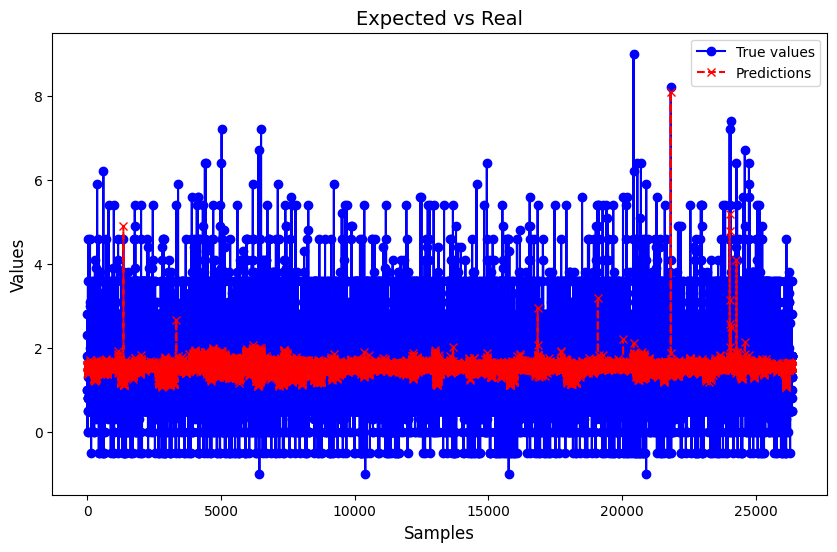

In [51]:
import matplotlib.pyplot as plt

# Tworzenie wykresu porównawczego
plt.figure(figsize=(10, 6))

# Rysowanie rzeczywistych wartości
plt.plot(y_test, label='True values', color='blue', linestyle='-', marker='o')

# Rysowanie przewidywanych wartości
plt.plot(predictions, label='Predictions', color='red', linestyle='--', marker='x')

# Dodanie tytułów i etykiet osi
plt.title('Expected vs Real', fontsize=14)
plt.xlabel('Samples', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Dodanie legendy
plt.legend()

# Wyświetlenie wykresu
plt.show()
